# Steric sea level change in the North East Atlantic

Steirc expansion is computed using EN4 and IAP data sets and the gsw package (https://github.com/TEOS-10/GSW-Python)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal
import importlib
import sys
sys.path.append('../code')
import SeaLevelContrib as slc

import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [3]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [4]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '/Users/dewilebars/Projects/SLBudget/notebooks/../code/SeaLevelContrib.py'>

In [5]:
data_path = '../data/DataSteric/'
data_IAP = data_path + 'DataStericIAP/'


In [6]:
def pearson_r_3D(ts, slab, anom=True):
    """
    Compute a 2D field of correlation coefficients,
    given a 1D-timeseries ('ts') and a 3D-field ('slab')
    """
    # compute anomalies if neccessary
    if not anom:
        ts = ts - np.nanmean(ts)
        slab = slab - np.expand_dims(np.nanmean(slab,axis=0),0)
    # 'ts' to match 3D shape of 'slab'
    ts_3D = np.rollaxis(np.rollaxis(np.reshape(
        np.tile(ts,slab.shape[1]*slab.shape[2]), 
        (slab.shape[2],slab.shape[1],len(ts))),2,0),2,1)
    # standard deviations
    ts_3D_slab_cov = np.nansum(ts_3D*slab,axis=0)
    ts_3D_stdev = np.sqrt(np.nansum(np.power(ts_3D,2),axis=0))
    slab_stdev = np.sqrt(np.nansum(np.power(slab,2),axis=0))
    # pearson correlation
    pearson = ts_3D_slab_cov / (ts_3D_stdev * slab_stdev)
    # done
    return pearson

## Explore the EN4 data over different integration depths and reference periods

In [7]:
dens_en4 = slc.read_density("EN4_22")


def compute_steric_sl(dens, min_depth, max_depth):
    '''Read density and compute steric sea level in cm between two depths'''
    
    thick = slc.thickness_from_depth(dens.depth)
    
    SumDens = dens.density * thick
    
    # Compute the steric sea level in cm for a given depth range
    steric_sl = (- SumDens.sel(depth=slice(min_depth,max_depth)).sum(dim='depth') 
                / dens.density[0 ,0 ,: ,:]) * 100
    
    steric_sl = steric_sl - steric_sl.sel(time=slice(1950,1970)).mean(dim='time')
    
    steric_sl["depth"] = f"Vertical average between {min_depth}-{max_depth} m"
    
    return steric_sl


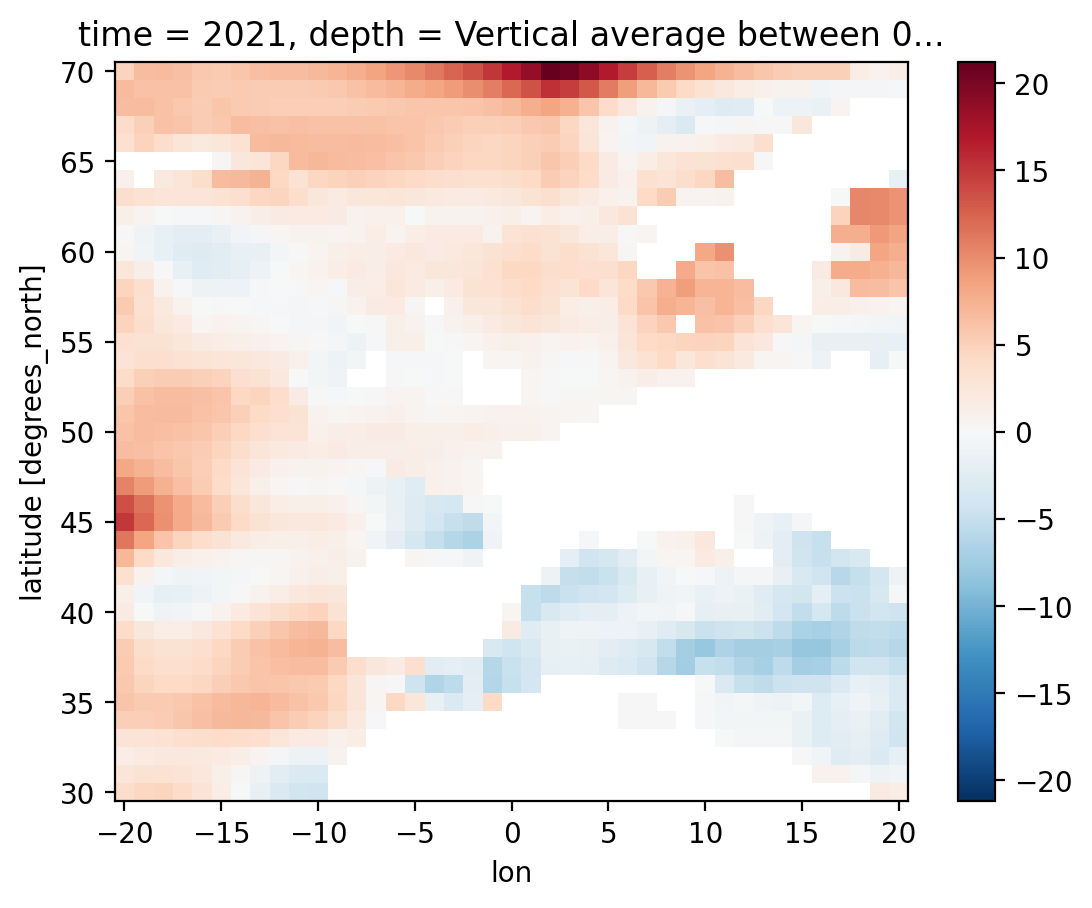

In [8]:
steric_sl_en4 = compute_steric_sl(dens_en4, 0, 2000)

steric_sl_en4.isel(time=-1).plot()

In [9]:
steric_sl_en4 = steric_sl_en4.sel(time=slice(1950,2022))

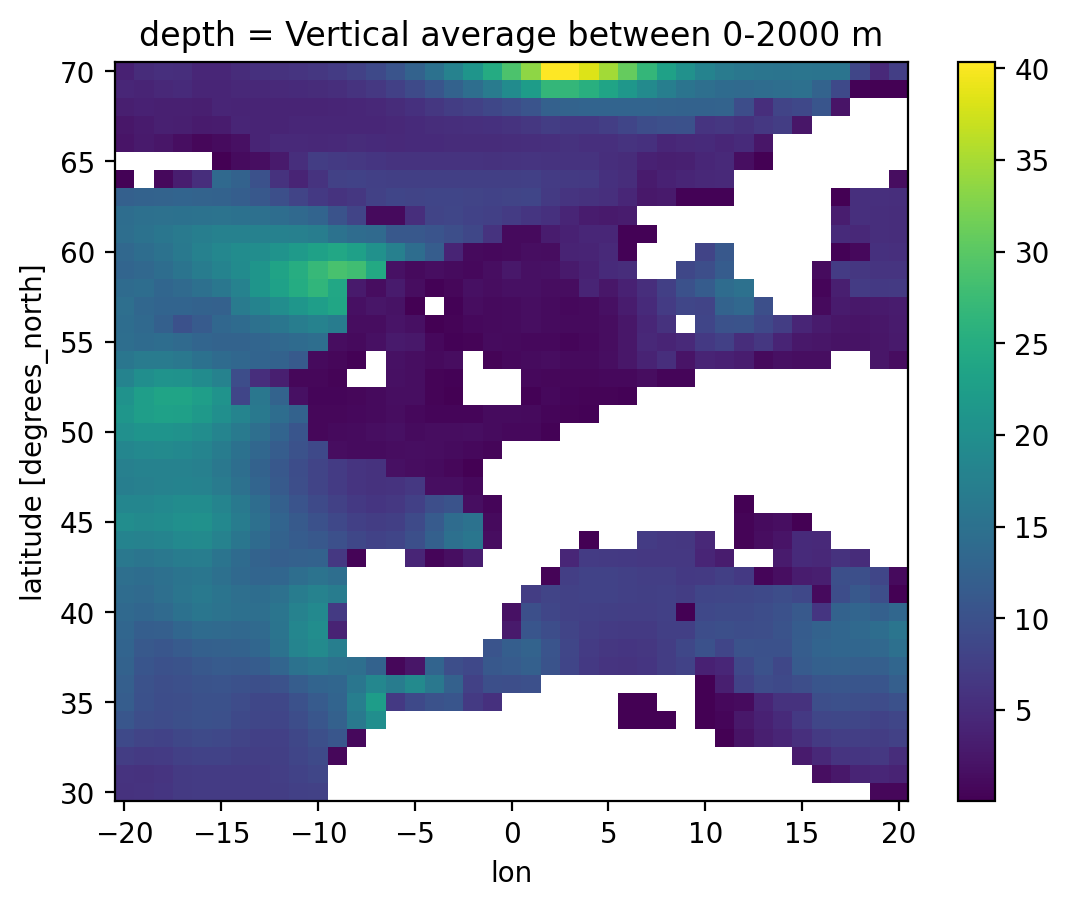

In [10]:
StericSLVar = steric_sl_en4.var(dim='time')
StericSLVar.plot()

## Compute the depth of the grid

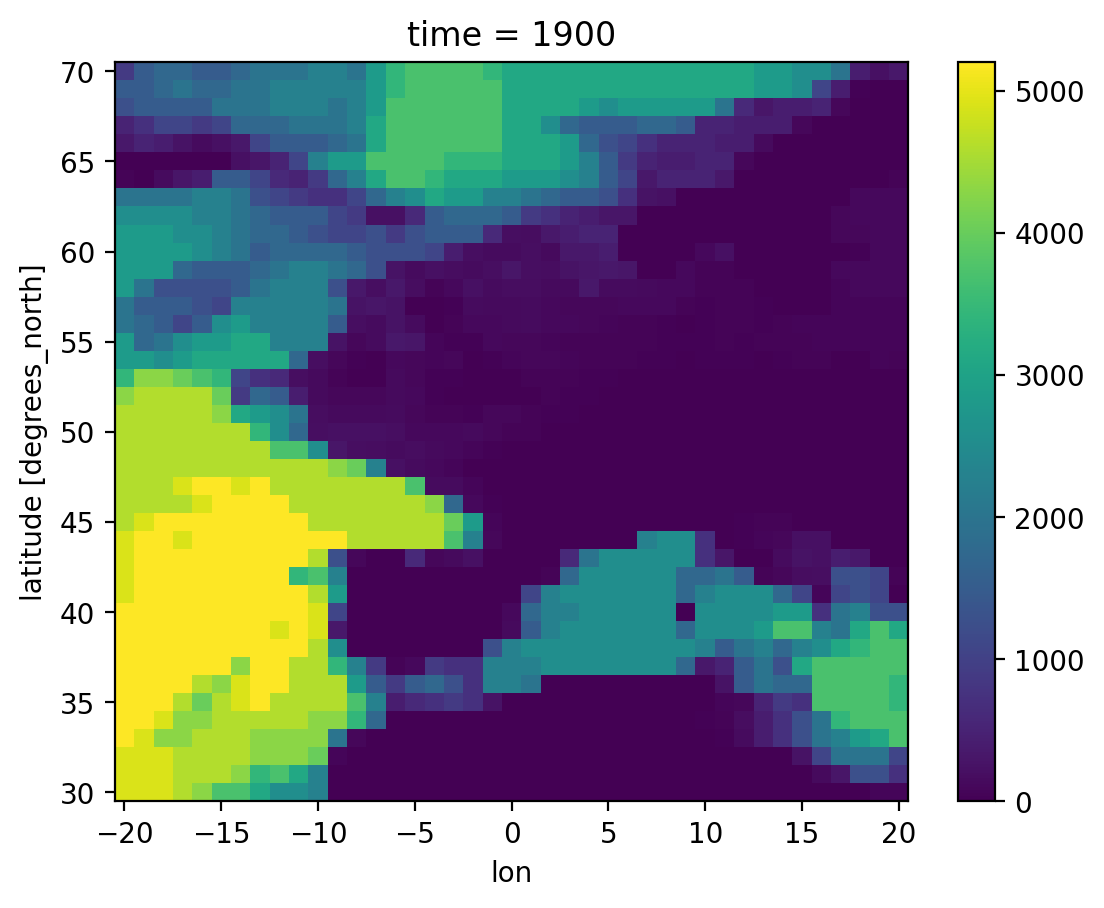

In [11]:
thick = slc.thickness_from_depth(dens_en4.depth)

Ones = xr.where(np.isnan(dens_en4.density[0,:,:,:]), np.NaN, 1)
DepthAr = (Ones * thick).sum(axis=0)
DepthArSel = xr.where(DepthAr == 0, np.NaN, DepthAr)
DepthAr.plot()

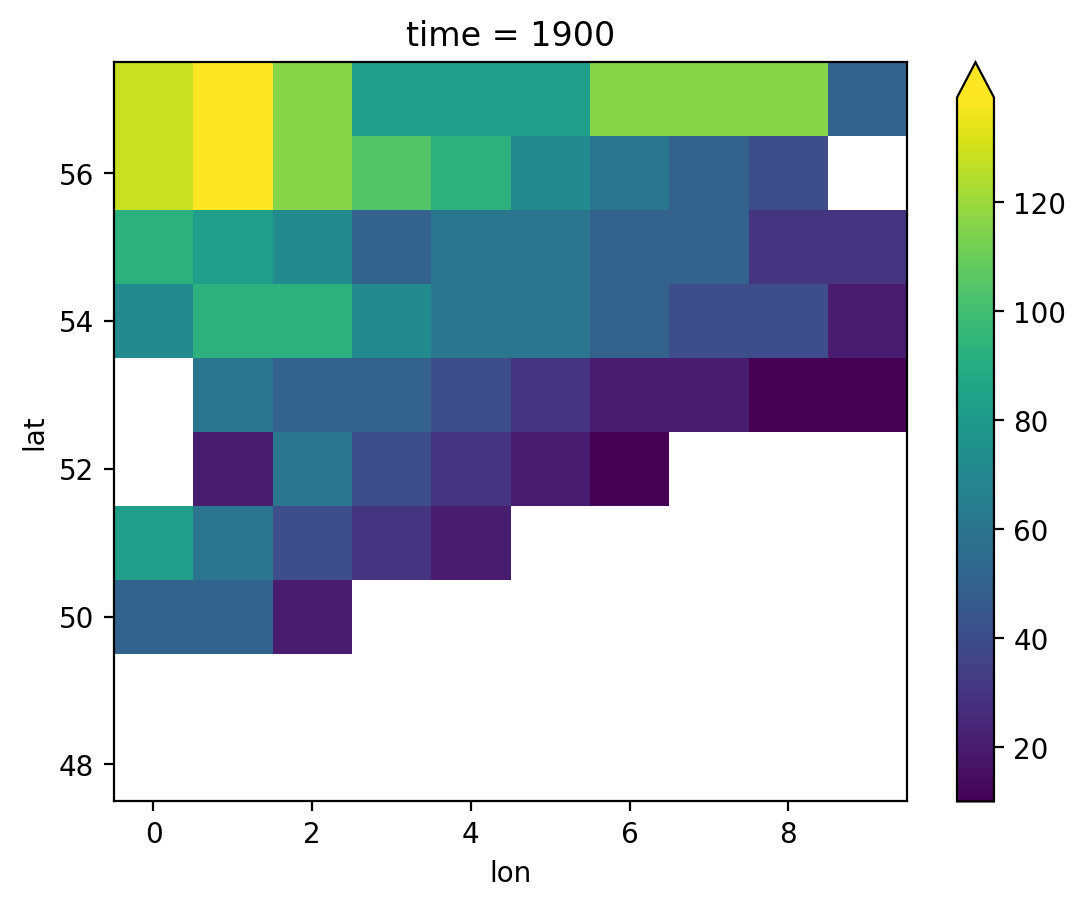

In [12]:
DepthArSel.sel(lat=slice(48,57), lon=slice(0,9)).plot(robust=True)

## Check the correlation between sea level time series and steric sea level

Read the csv file of a sea level budget. Remove all known contributors to sea level from the observations and check the residual.

In [13]:
b_df = pd.read_csv(f'../outputs/slbudget_2022_11_23_ZSM_tide_gauge_1950_2021_ERA5_StericEN4_22_[500, 4000]m.csv')
#b_df = pd.read_csv(f'../outputs/slbudget_2022_11_22_NL_region_altimetry_1993_2021_ERA5_StericIAP_2000m.csv')
#Projects/SLBudget/outputs/slbudget_2022_11_23_ZSM_tide_gauge_1950_2021_ERA5_StericEN4_22_[500, 4000]m.csv

b_df = b_df.set_index('time')

nt = b_df.loc[:,'GIA':'Pressure'].sum(axis=1)
diff_df = b_df.Obs - nt


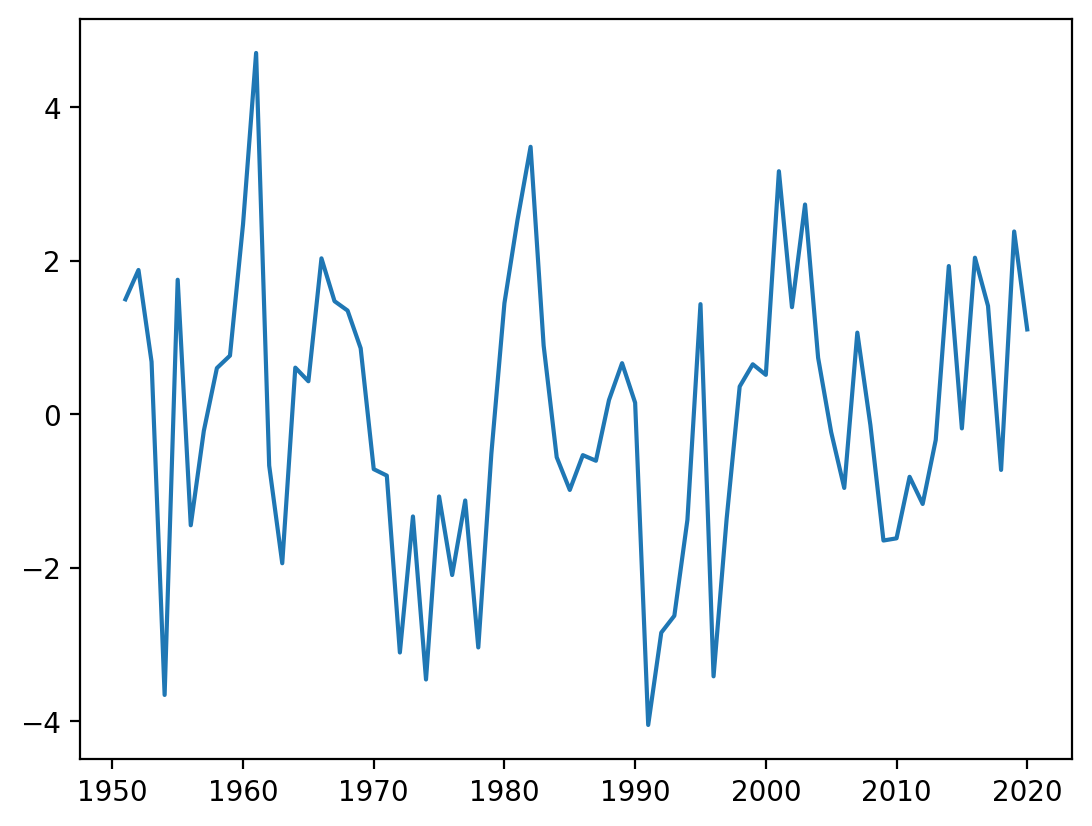

In [14]:
plt.plot(diff_df.index[1:-1], signal.detrend(diff_df.iloc[1:-1])) #.plot()

/var/folders/4x/jddrv9056c3bmvydrhcmv4gw0000gn/T/ipykernel_17450/2608539325.py:19: RuntimeWarning: invalid value encountered in divide
  pearson = ts_3D_slab_cov / (ts_3D_stdev * slab_stdev)


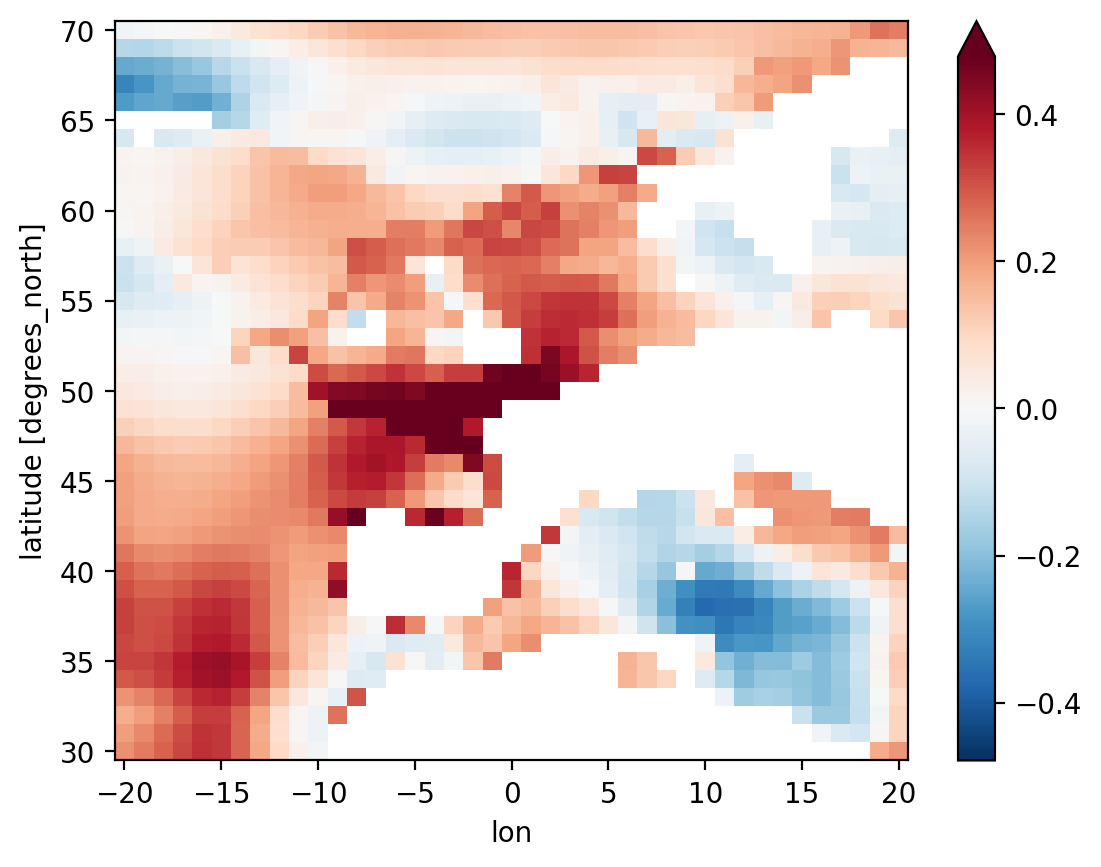

In [16]:
min_y, max_y = 1950, 2021

# Compute the correlation of the detrended data set, with a running mean of 3 years
StericSL_noNaN = xr.where(np.isnan(steric_sl_en4), 0, steric_sl_en4)

StericSLcor_dt = pearson_r_3D(signal.detrend(diff_df.loc[min_y+1:max_y-1]), 
                              signal.detrend( StericSL_noNaN.sel( time=slice( min_y, max_y)).rolling(time=3, center=True).mean().dropna('time'), axis=0)
                              , anom=False)

StericSLcor_dt = xr.DataArray(StericSLcor_dt, dims=['lat', 'lon'], 
                           coords={'lat' : steric_sl_en4.lat, 'lon' : steric_sl_en4.lon})
StericSLcor_dt.plot(robust=True)

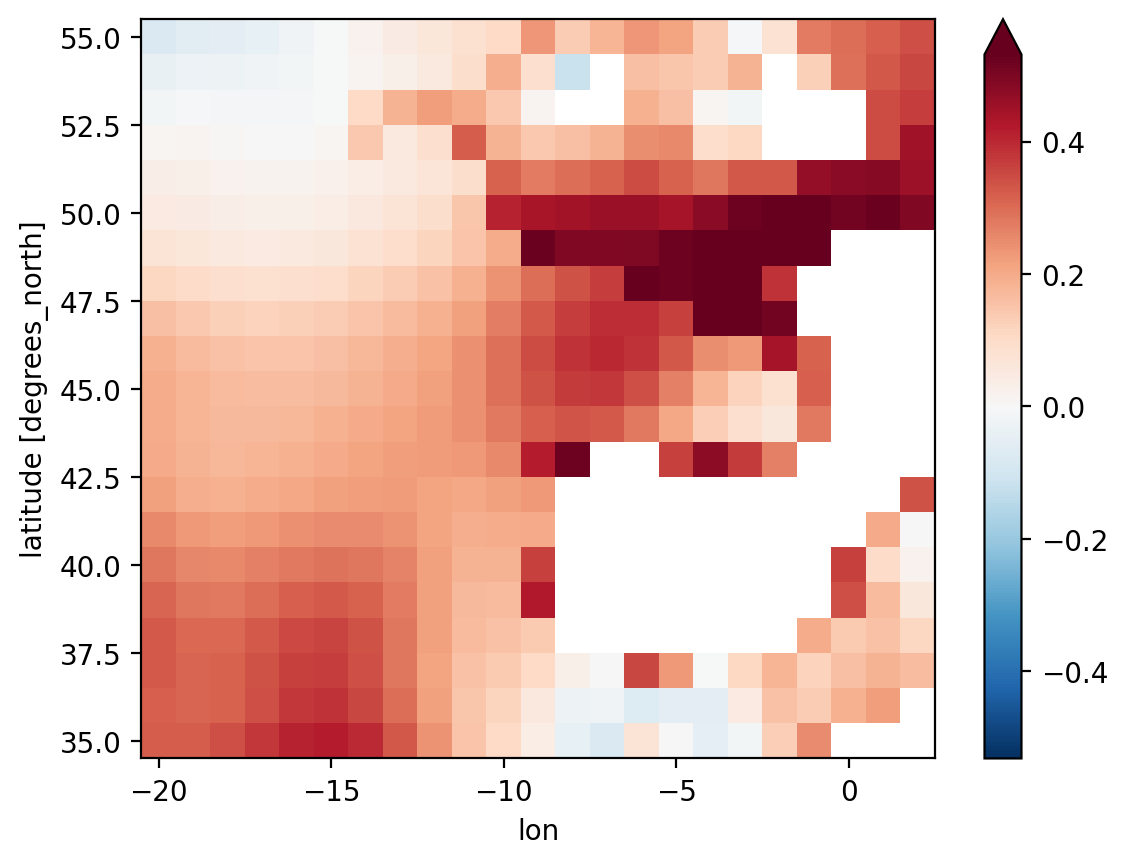

In [17]:
StericSLcor_dt.sel(lat=slice(35, 55), lon=slice(-20,2)).plot(robust=True)

The result depends a lot on the choice of the tide gauge even for the Dutch coast. Compare for example Vlissingen and Hoek van Holland.

## Plot a few region masks over which the steric effect can be computed

In [19]:
mask_ENS = slc.steric_masks_north_sea(dens_en4.density, 'ENS')
mask_ENS = xr.where(np.isnan(mask_ENS), 0, 1)

mask_EBB = slc.steric_masks_north_sea(dens_en4.density, 'EBB')
mask_EBB = xr.where(np.isnan(mask_EBB), 0, 1)

mask_NWS = slc.steric_masks_north_sea(dens_en4.density, 'NWS')
mask_NWS = xr.where(np.isnan(mask_NWS), 0, 1)

mask_BB = slc.steric_masks_north_sea(dens_en4.density, 'BB')
mask_BB = xr.where(np.isnan(mask_BB), 0, 1)

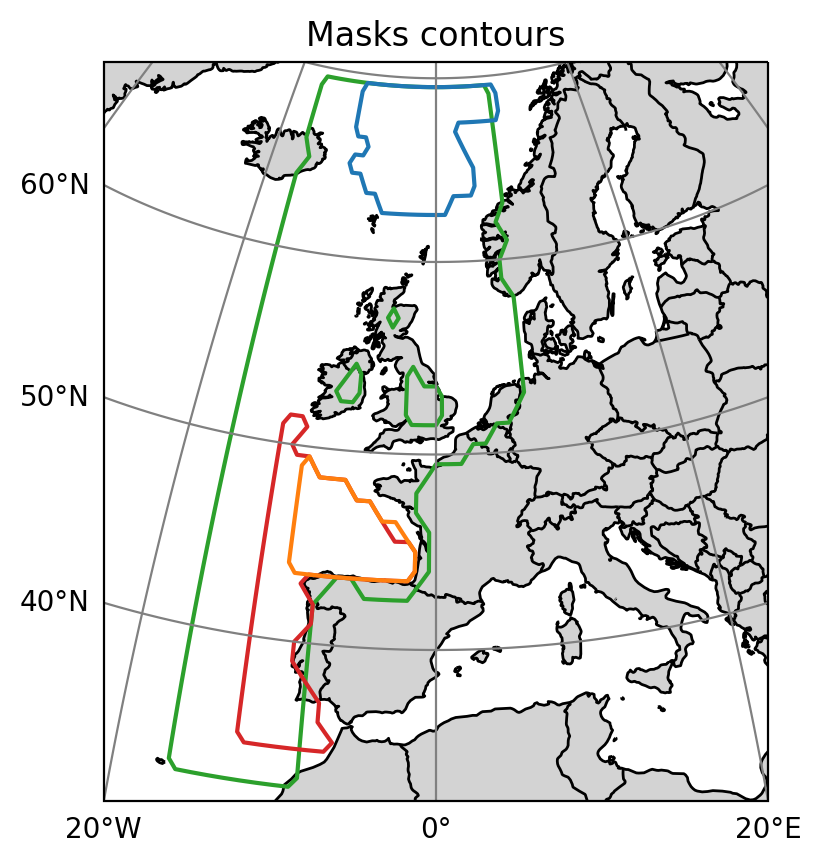

In [20]:
lon_min, lon_max, lat_min, lat_max = -20, 20, 30, 70

fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.Orthographic(0, 45))

mask_ENS.plot.contour(
    transform=ccrs.PlateCarree(),
    levels=[0.5],
    colors="tab:green",
    ax=ax)

mask_EBB.plot.contour(
    transform=ccrs.PlateCarree(),
    levels=[0.5],
    colors="tab:red",
    ax=ax)

mask_NWS.plot.contour(
    transform=ccrs.PlateCarree(),
    levels=[0.5],
    colors="tab:blue",
    ax=ax)

mask_BB.plot.contour(
    transform=ccrs.PlateCarree(),
    levels=[0.5],
    colors="tab:orange",
    ax=ax)

ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.BORDERS)
ax.coastlines()

gl = ax.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

plt.title('Masks contours');

### Prepare a nicer figure of masks for talks

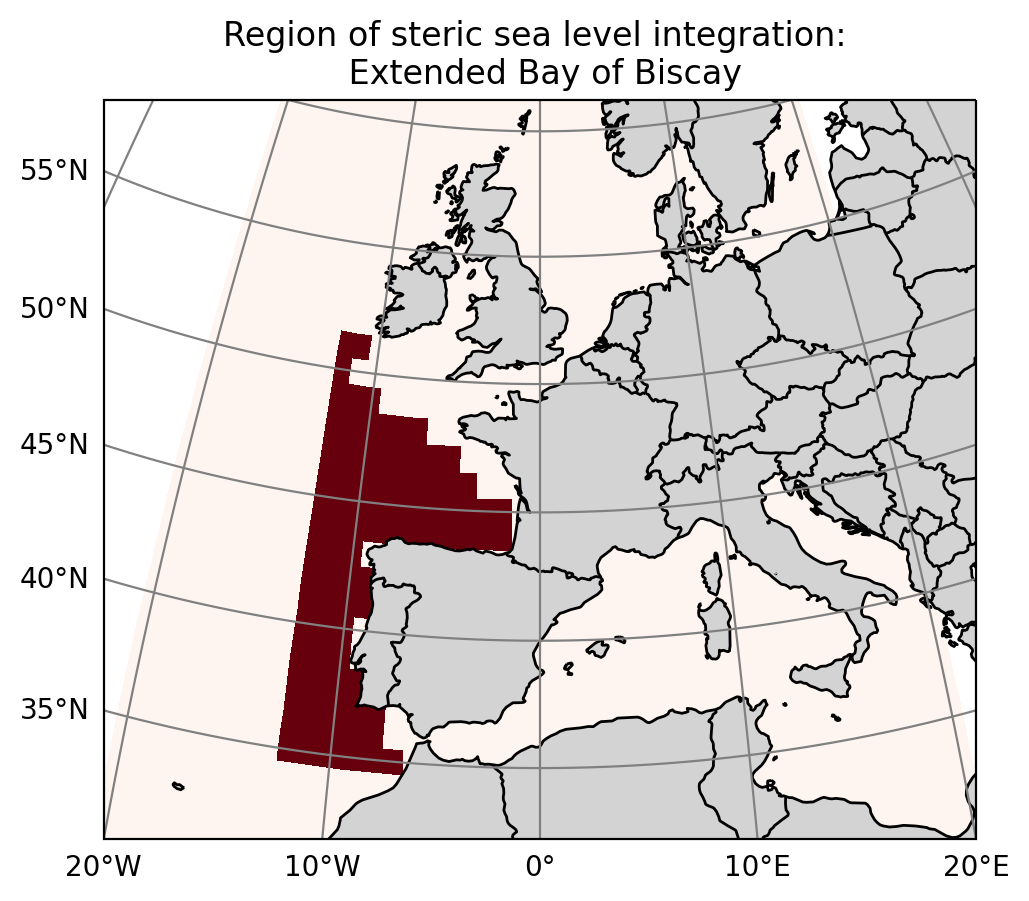

In [21]:
lon_min, lon_max, lat_min, lat_max = -20, 20, 30, 60

p = mask_EBB.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 45), facecolor='lightgray'), 
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    add_colorbar=False,
    zorder=0)

p.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)
p.axes.add_feature(cfeature.OCEAN, facecolor='white')
p.axes.add_feature(cfeature.BORDERS)
p.axes.coastlines()

gl = p.axes.gridlines(color='grey', linestyle='-', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
p.axes.set_extent([lon_min, lon_max, lat_min, lat_max])
#cb = fig.colorbar()
#cb.remove()
plt.title('Region of steric sea level integration: \n Extended Bay of Biscay');

#plt.savefig('../figures/StericMaskRegionEBB.pdf', dpi=150)

## Compare steric sea level in the different regions

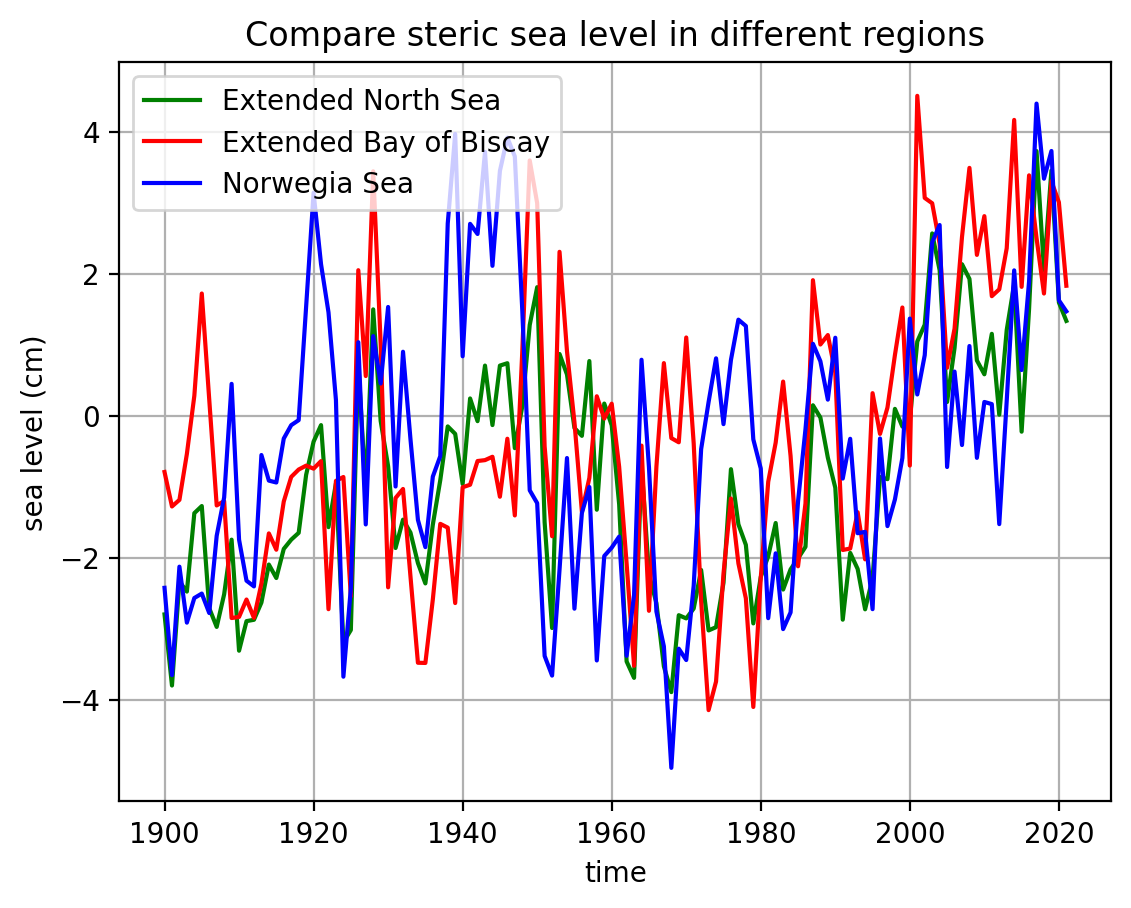

In [22]:
max_depth = 1000

StericSL_ENS_df = slc.StericSL('EN4_22', 'ENS', 0, max_depth, 0)
StericSL_EBB_df = slc.StericSL('EN4_22', 'EBB', 0, max_depth, 0)
StericSL_NWS_df = slc.StericSL('EN4_22', 'NWS', 0, max_depth, 0)

#Plot time series
fig, ax = plt.subplots()
ax.plot(StericSL_ENS_df, 'g-', label='Extended North Sea')
ax.plot(StericSL_EBB_df, 'r-', label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df, 'b-', label='Norwegia Sea')

#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric sea level in different regions')
ax.grid(True)
plt.legend(loc='upper left')

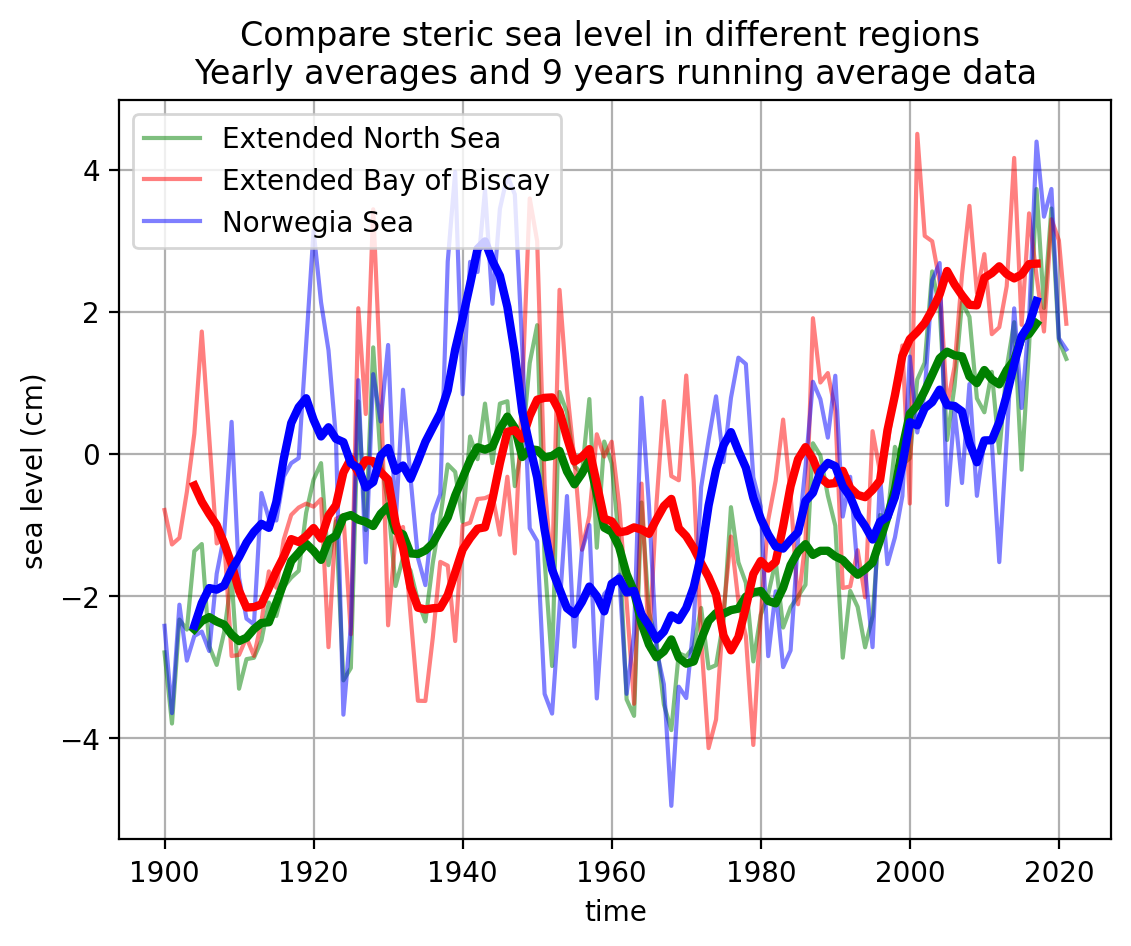

In [23]:
#Plot time series
fig, ax = plt.subplots()
ax.plot(StericSL_ENS_df, 'g-', alpha=0.5, label='Extended North Sea')
ax.plot(StericSL_EBB_df, 'r-', alpha=0.5, label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df, 'b-', alpha=0.5, label='Norwegia Sea')

ax.plot(StericSL_ENS_df.rolling(9, center=True).mean(), 'g-', linewidth=3)
ax.plot(StericSL_EBB_df.rolling(9, center=True).mean(), 'r-', linewidth=3)
ax.plot(StericSL_NWS_df.rolling(9, center=True).mean(), 'b-', linewidth=3)

#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric sea level in different regions \n'+
         'Yearly averages and 9 years running average data')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/ComparisonStericDifferentRegions.pdf', dpi=150)

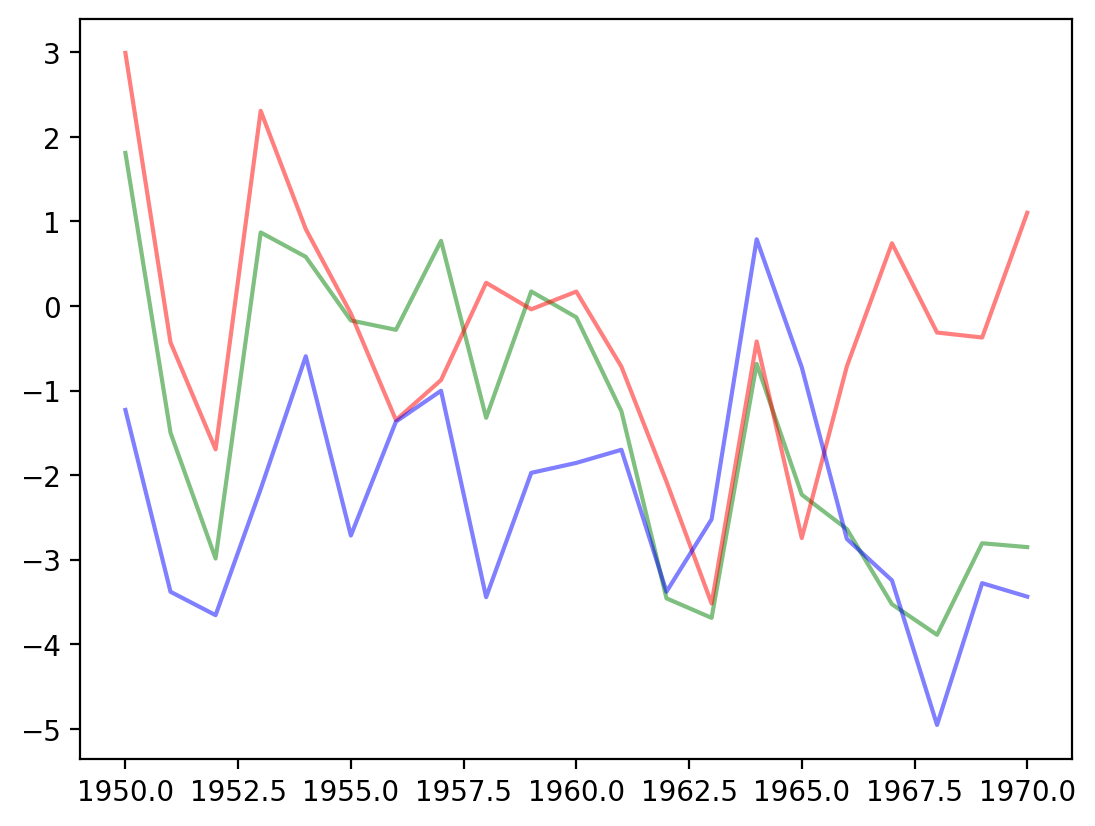

In [24]:
fig, ax = plt.subplots()
ax.plot(StericSL_ENS_df.loc[1950:1970], 'g-', alpha=0.5, label='Extended North Sea')
ax.plot(StericSL_EBB_df.loc[1950:1970], 'r-', alpha=0.5, label='Extended Bay of Biscay')
ax.plot(StericSL_NWS_df.loc[1950:1970], 'b-', alpha=0.5, label='Norwegia Sea')

## Compare with the global mean steric sea level anomaly from NOAA, Levitus

In [26]:
#Global mean total sea level anomaly (NOAA, Levitus)
LevitusSL_df = slc.LevitusSL()
#LevitusSL_NA_df = slc.LevitusSL('NA')
FredGlo_df = slc.contrib_frederikse2020_glob('GloSteric')


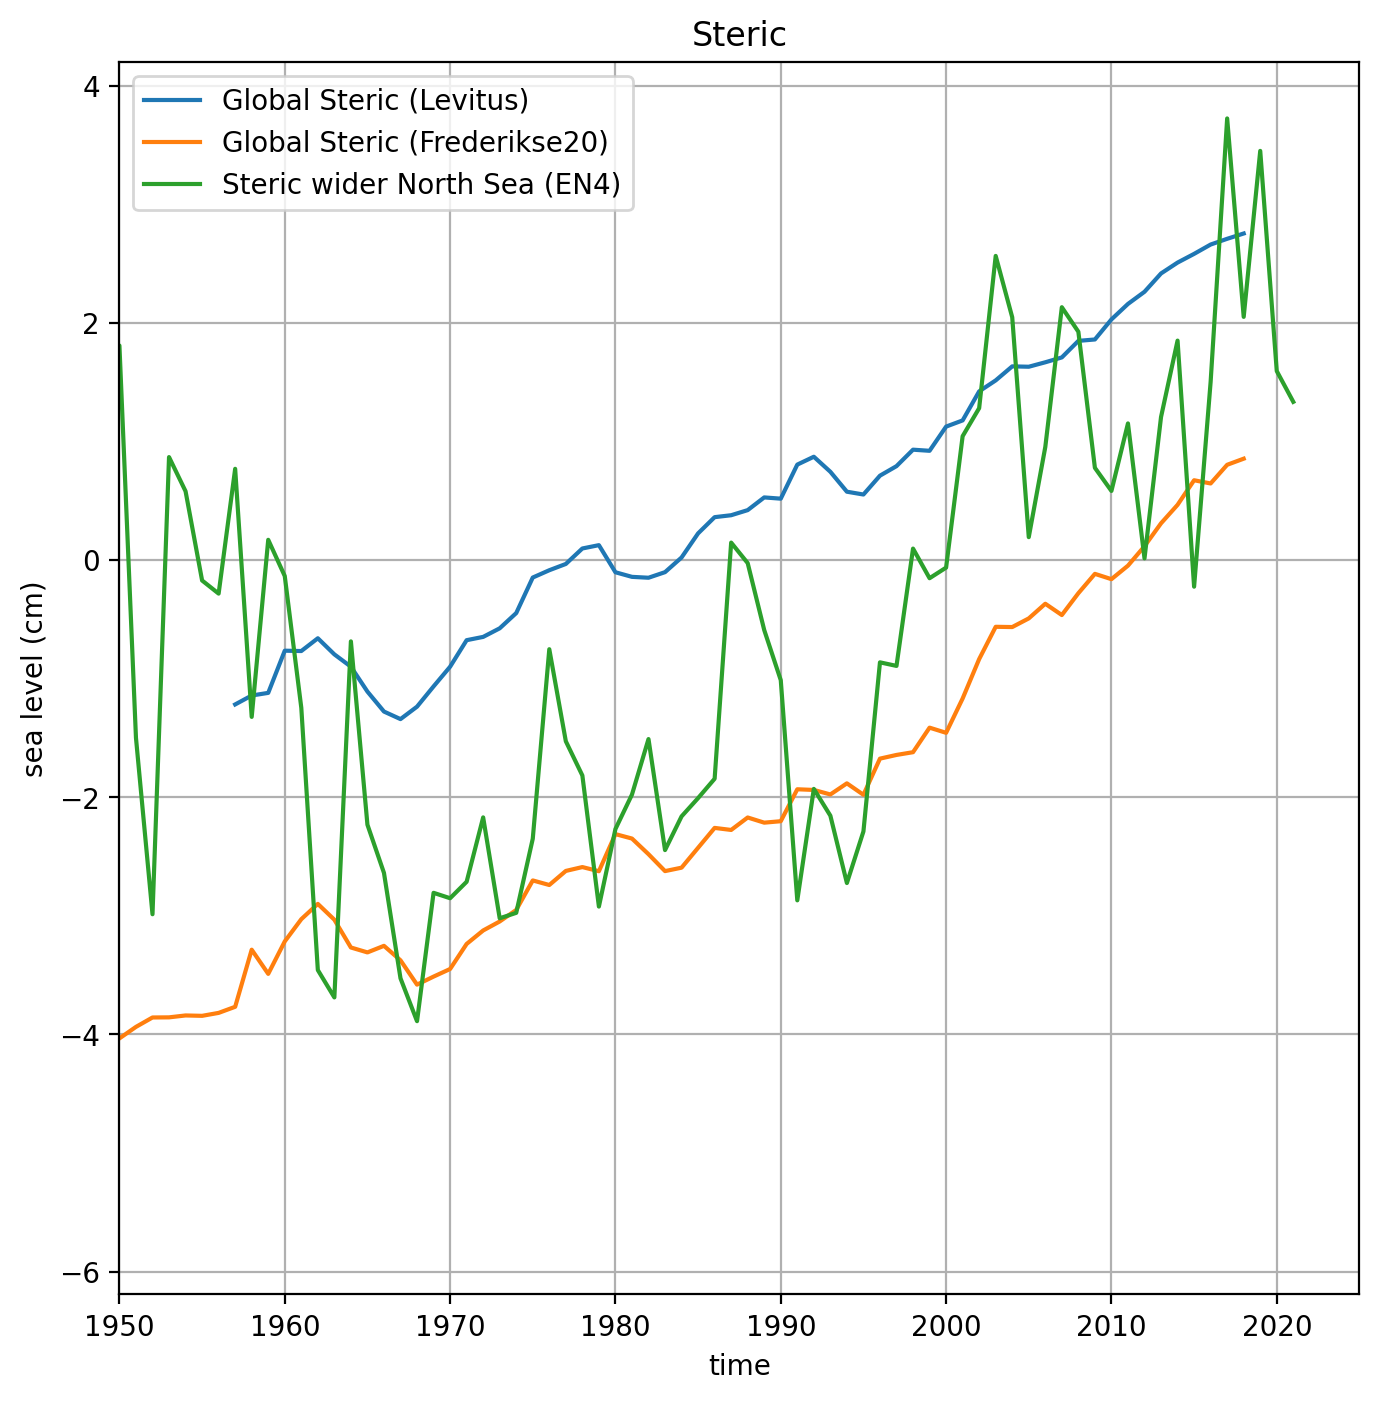

In [27]:
#Plot time series
fig, ax = plt.subplots(figsize=(8,8))
#ax.plot(SeaLevel_df.height, 'r-') #From mm to cm
#ax.plot(StericSL_NS_df, 'b-')
ax.plot(LevitusSL_df, label='Global Steric (Levitus)')
ax.plot(FredGlo_df, label='Global Steric (Frederikse20)')
#ax.plot(LevitusSL_NA_df, label='North Atlantic Steric(Levitus)')
#ax.plot(StericSLreg_df, label='Steric Bay biscay (EN4)')
ax.plot(StericSL_ENS_df, label='Steric wider North Sea (EN4)')
#ax.set_aspect(1)
ax.set_xlim([1950,2025])
plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Steric')
plt.legend(loc='upper left')
ax.grid(True)

#plt.savefig('./Figures/ComparisonGloLocSteric', dpi=150)
#plt.savefig('~/Downloads/ComparisonGloLocSteric', dpi=150)

### Compare Levitus pentad data that stop in 2018 with the yearly data that goes on to 2019

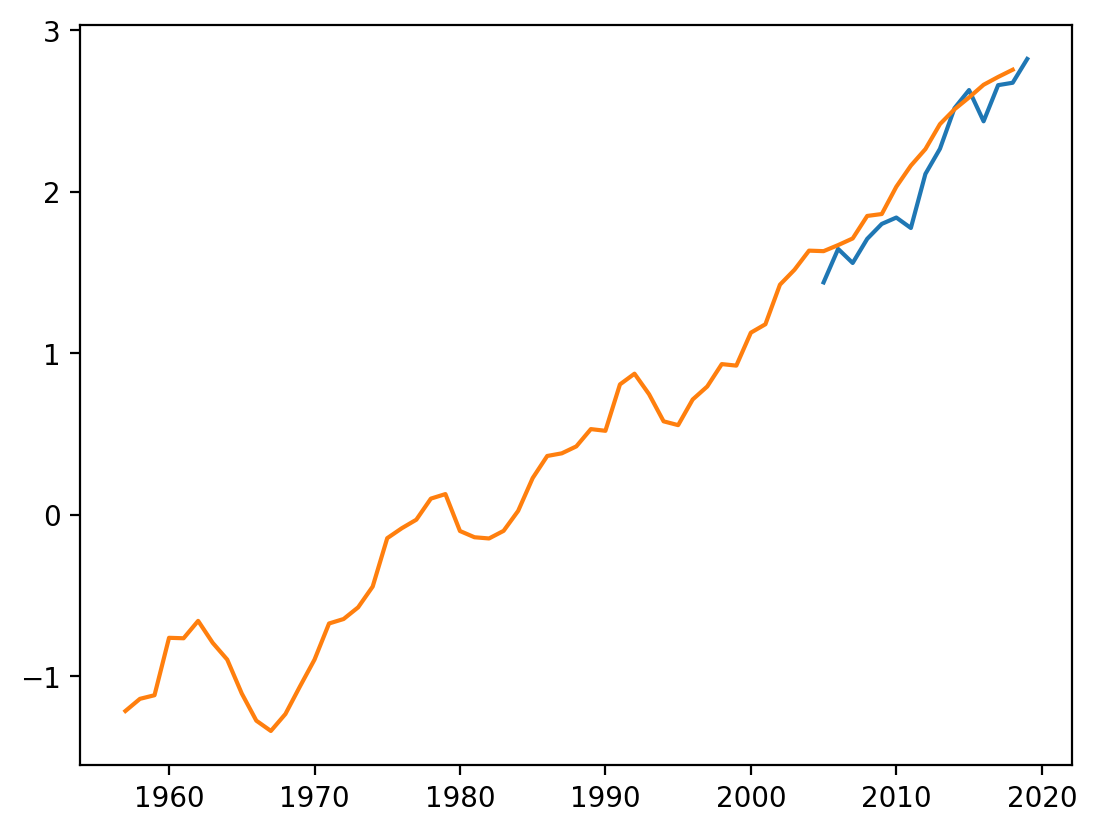

In [28]:
PATH_Data = '/Users/dewilebars/Data/'
Dir_LEV = PATH_Data + 'NOAA/'

Lev_ds = xr.open_dataset(Dir_LEV + \
                         'mean_total_steric_sea_level_anomaly_0-2000_yearly.nc', \
                         decode_times=False)
LevitusSL_y = Lev_ds.yearl_s_mm_WO.copy() / 10

# Convert from months since 1955 to years
LevitusSL_y['time'] = LevitusSL_y.time / 12 + 1955 - .5
LevitusSL_y['time'] = LevitusSL_y.time.astype(int)
LevitusSL_y_df = LevitusSL_y.to_dataframe()

plt.plot(LevitusSL_y_df.iloc[:-1])
plt.plot(LevitusSL_df)

Conclusion: The yearly data only adds one year so it is not worth it.

## Explore steric sea level from Cheng et al. 2017

### Check the precomputed steric sea level

In [29]:
# Read data preprocessed by DensityIAP_month2year.py
IAP_ds = xr.open_dataset(data_IAP+'Steric_IAP_2000m_yearly_1940_2019.nc')
IAP_ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, depth_std: 41, time: 80)
Coordinates:
  * lat        (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * depth_std  (depth_std) float32 1.0 5.0 10.0 20.0 ... 1.7e+03 1.8e+03 2e+03
  * time       (time) int64 1940 1941 1942 1943 1944 ... 2016 2017 2018 2019
Data variables:
    SSL_2000m  (time, lat, lon) float32 ...
    SSL_1500m  (time, lat, lon) float32 ...
    SSL_700m   (time, lat, lon) float32 ...
    SSL_300m   (time, lat, lon) float32 ...
    SSL_100m   (time, lat, lon) float32 ...

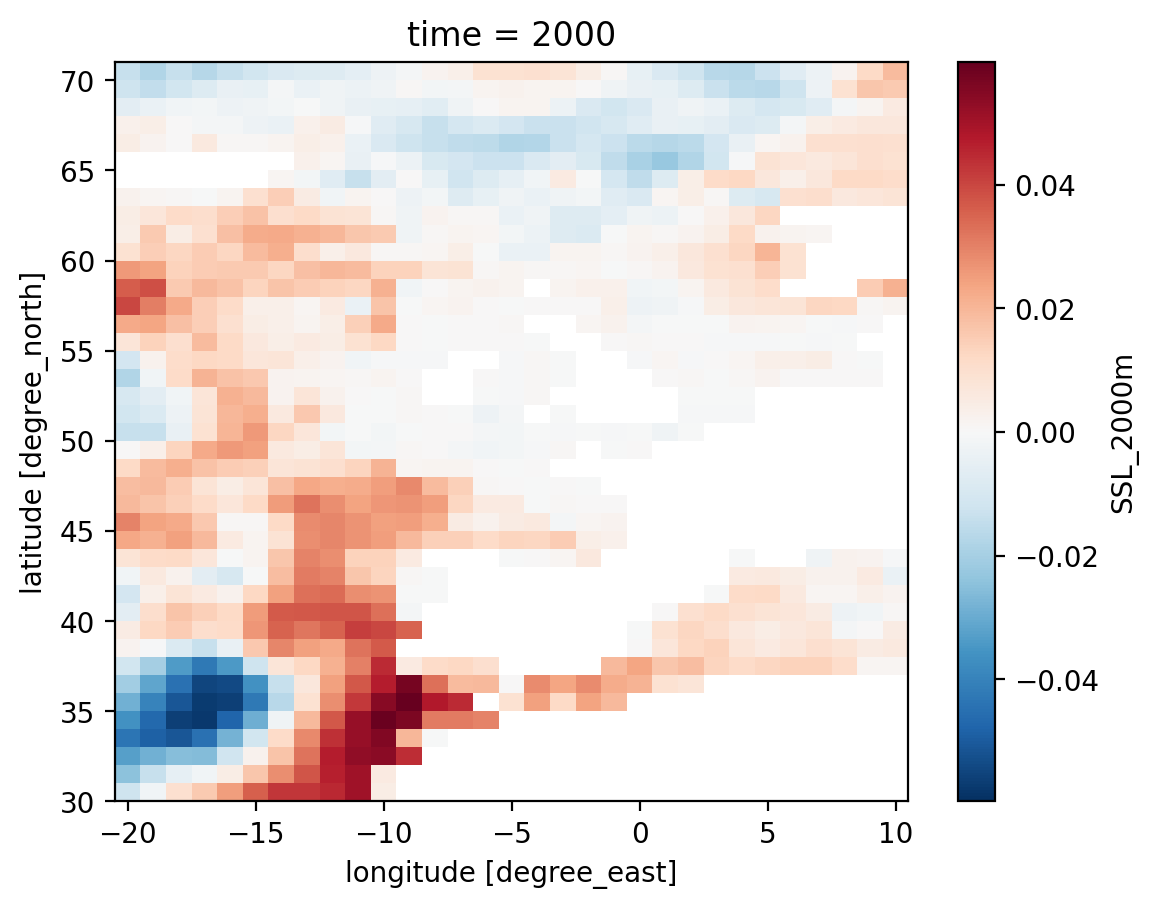

In [30]:
IAP_ds.SSL_2000m.sel(time=2000,lat=slice(30.5,70.5),lon=slice(-20,10)).plot()

It is not possible to have the same method as used in EN4 with the steric data provided by IAP. For EN4 I downloaded the salinity and temperature fields and then computed the 3D steric expansion at each vertical level. This allowed to average steric sea level over larger areas.

It would be more consistent to do the same here with the IAP data. It also gives me a better handle on the exact way the expansion is computed.

In the meantime the Extended Bay of Biscay and Norwegian Sea regions can be used.

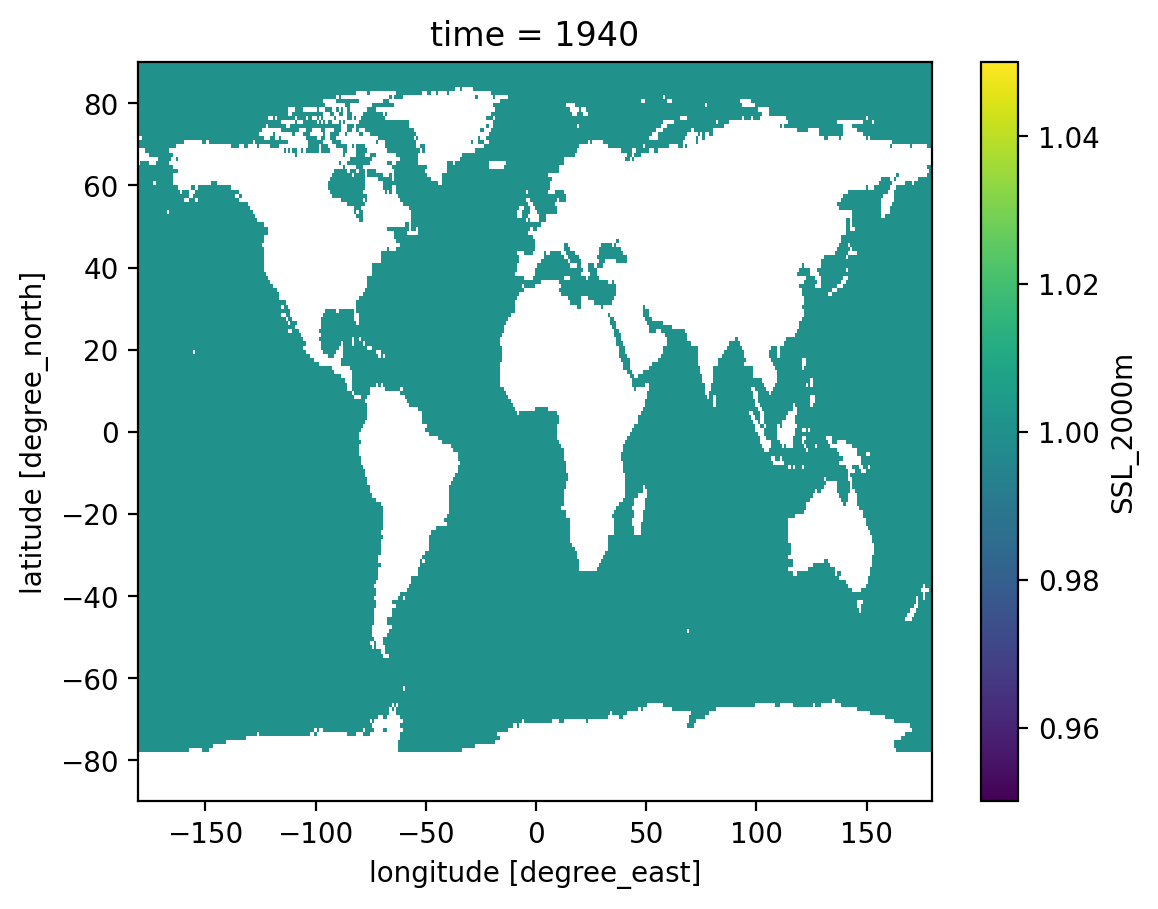

In [31]:
mask = xr.where(np.isnan(IAP_ds.SSL_2000m[0,:,:]), np.nan, 1)
mask.plot()

In [32]:
def steric_masks_IAP2D(da, mask_name):
    if mask_name == 'ENS':
        # Extended North Sea mask
        lat = np.array(da.lat)
        lon = np.array(da.lon)
        LatAr = np.repeat(lat[:,np.newaxis], len(lon), 1)
        LatAr = xr.DataArray(LatAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})
        LonAr = np.repeat(lon[np.newaxis,:], len(lat), 0)
        LonAr = xr.DataArray(LonAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})

        mask_med = xr.where(np.isnan(da[0,:,:]), np.nan, 1)
        mask_med1 = mask_med.where((LonAr >= -8) & (LatAr <= 42) )
        mask_med1 = xr.where(np.isnan(mask_med1), 1, np.nan)
        mask_med2 = mask_med.where((LonAr >= 1) & (LatAr <= 48) )
        mask_med2 = xr.where(np.isnan(mask_med2), 1, np.nan)
        mask_med = mask_med * mask_med1 * mask_med2

        mask = xr.where(np.isnan(da[0,:,:]), np.nan, 1)
        mask = mask.where(mask.lon <= 7)
        mask = mask.where(mask.lon >= -16)
        mask = mask.where(mask.lat <= 69) #Normal value: 60 or 69
        mask = mask.where(mask.lat >= 33)
        mask = mask * mask_med
    del mask['time']
    return mask

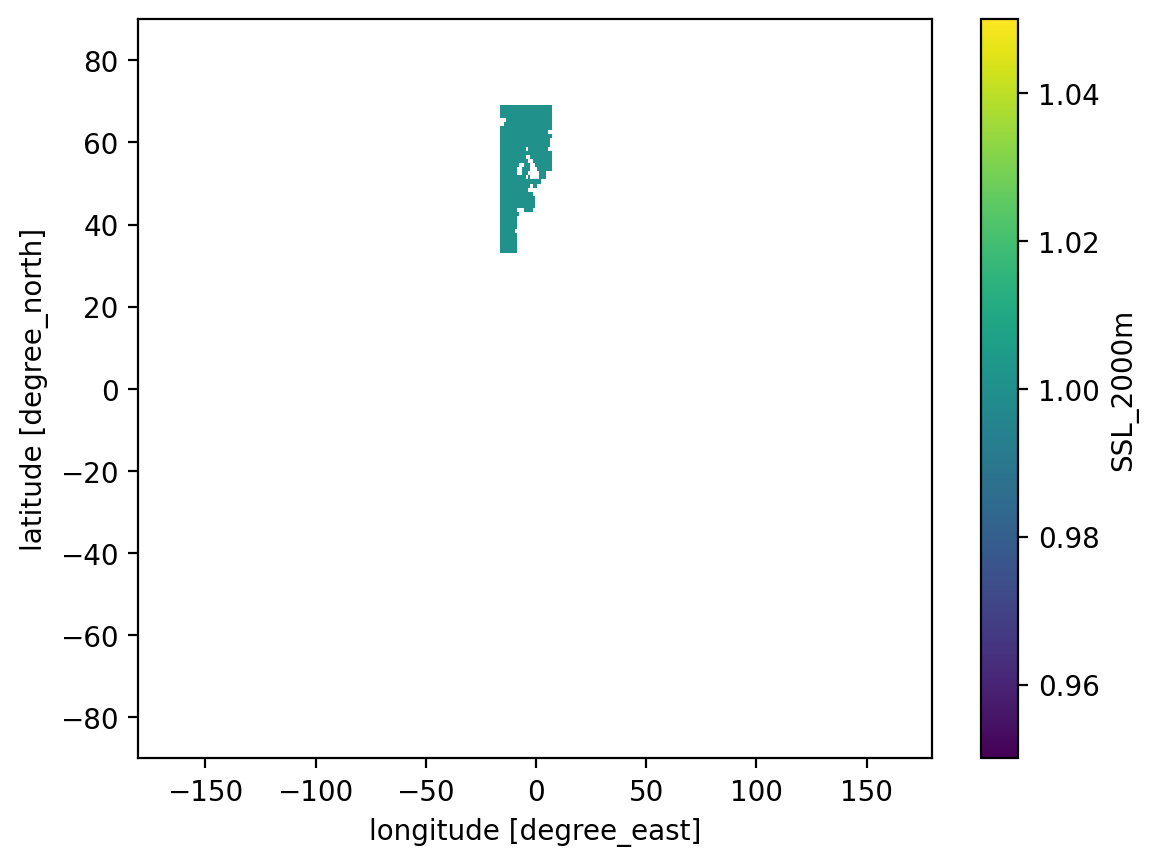

In [33]:
mask_ENS = steric_masks_IAP2D(IAP_ds.SSL_2000m, 'ENS')
mask_ENS.plot()

### Look into the 3D density files computed from IAP temperature and salinity (Cheng et al. 2017)

In [36]:
steric_ENS_IAP = slc.StericSL('IAP', 'ENS', 0, 1000, 0).rename(columns={'Steric': 'ENS'})
steric_EBB_IAP = slc.StericSL('IAP', 'EBB', 0, 1000, 0).rename(columns={'Steric': 'EBB'})
steric_NWS_IAP = slc.StericSL('IAP', 'NWS', 0, 1000, 0).rename(columns={'Steric': 'NWS'})


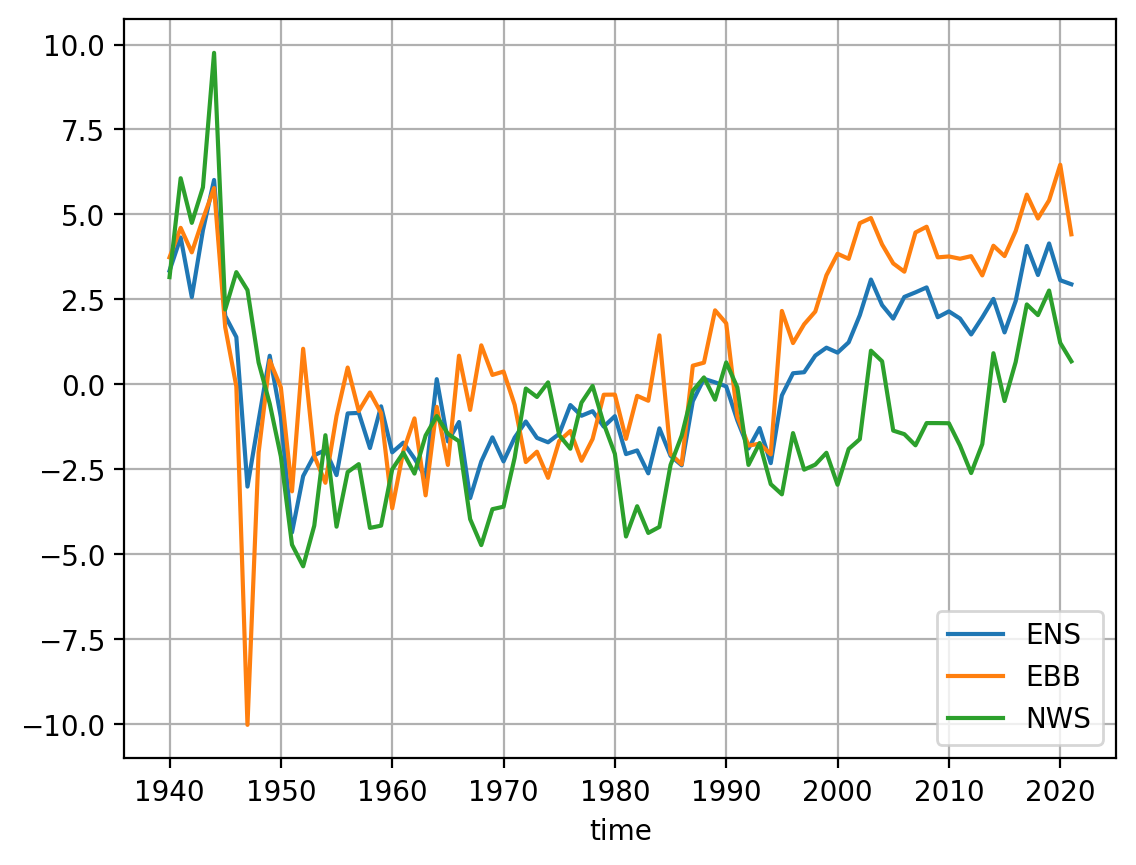

In [37]:
fig, ax = plt.subplots()

steric_ENS_IAP.plot(ax=ax)
steric_EBB_IAP.plot(ax=ax)
steric_NWS_IAP.plot(ax=ax)

ax.grid(True)
plt.legend()

### Compare steric sea level from IAP and from EN4

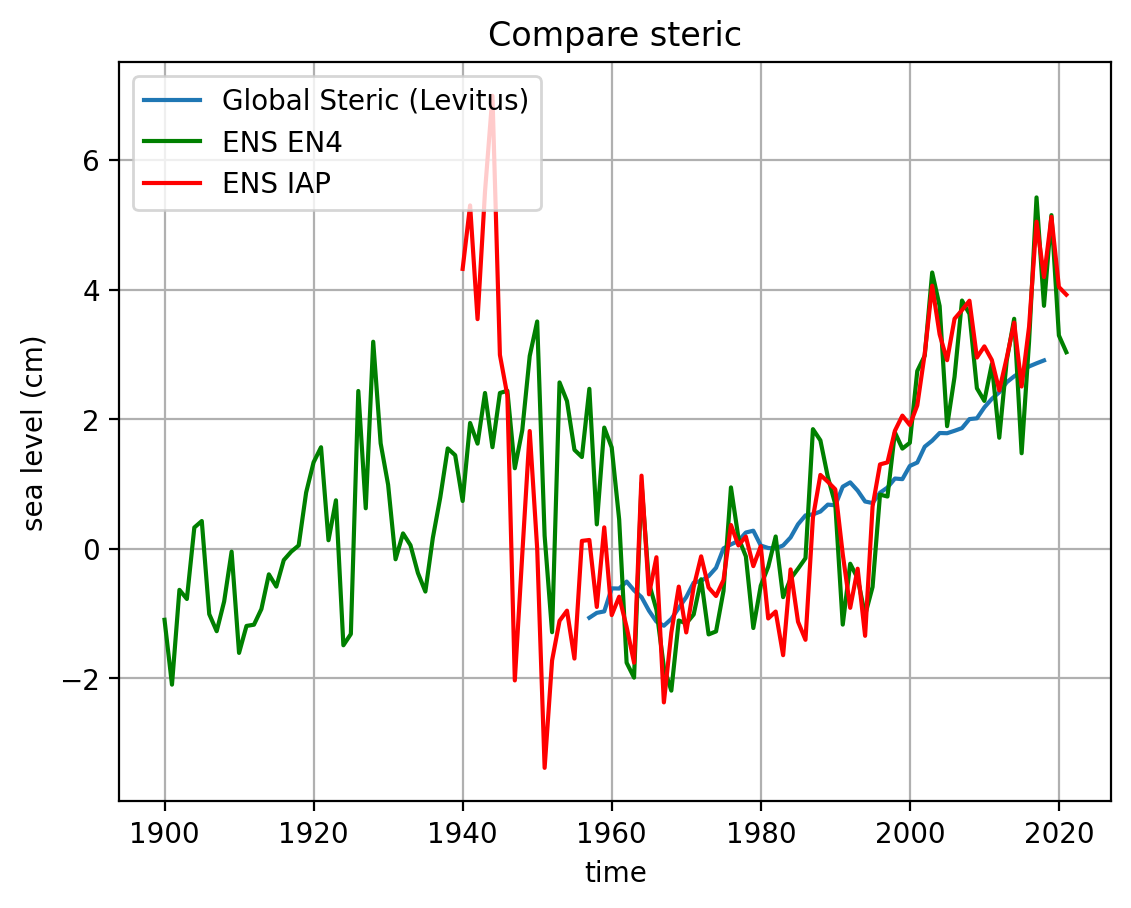

In [39]:
#Plot time series
fig, ax = plt.subplots()
ax.plot(LevitusSL_df - LevitusSL_df.loc[970:2000].mean(), label='Global Steric (Levitus)')
ax.plot(StericSL_ENS_df - StericSL_ENS_df.loc[1970:2000].mean(), 'g-', label='ENS EN4')
ax.plot(steric_ENS_IAP - steric_ENS_IAP.loc[1970:2000].mean(), 'r-', label='ENS IAP')
#ax.plot(SeaLevel_df.height, 'y-', label='Tide gauge')
#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/Steric_EN4_IAP_ArroundNorthSea_top2000m.pdf', dpi=150)

The IAP data has a strange drop of steric sea level in the 1940s. This drop is not found in the data nor in EN4.

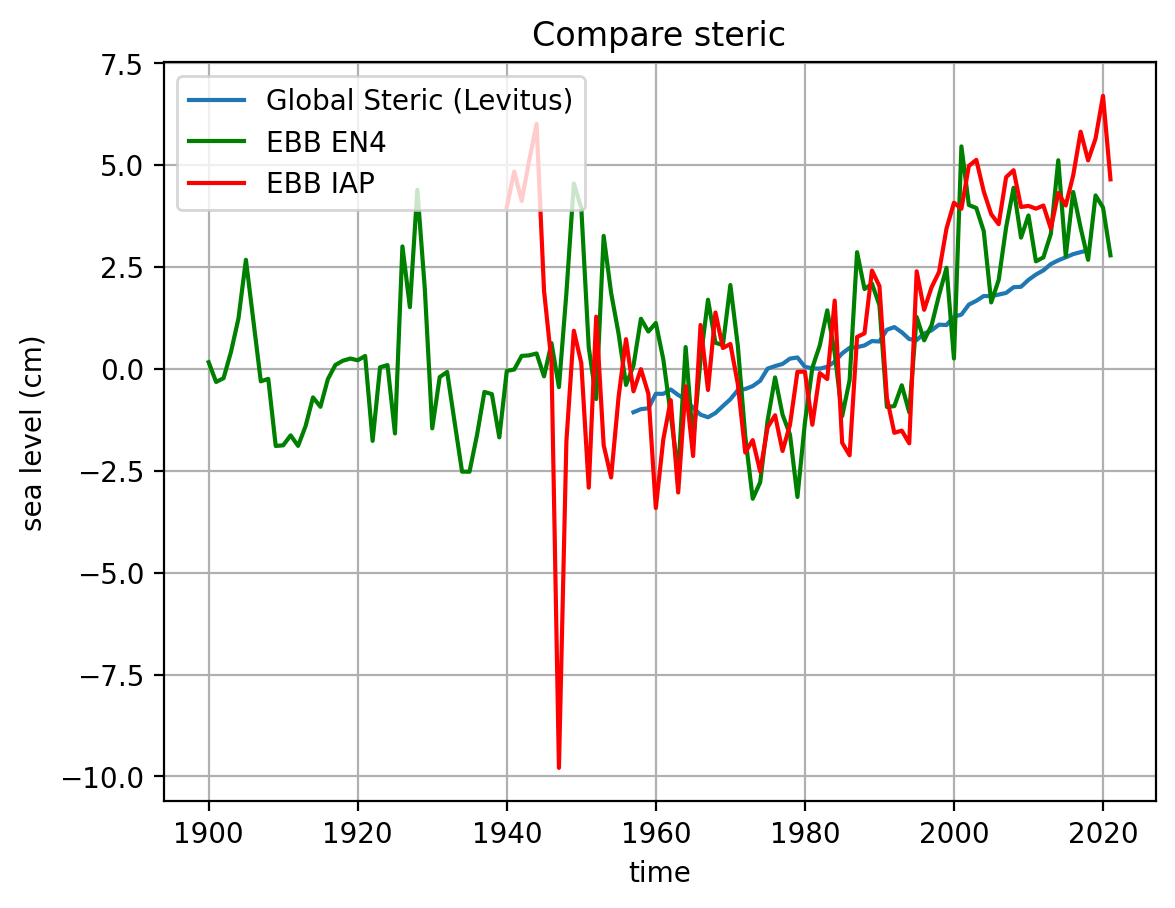

In [40]:
#Plot time series
fig, ax = plt.subplots()
ax.plot(LevitusSL_df - LevitusSL_df.loc[970:2000].mean(), label='Global Steric (Levitus)')
ax.plot(StericSL_EBB_df - StericSL_EBB_df.loc[1970:2000].mean(), 'g-', label='EBB EN4')
ax.plot(steric_EBB_IAP - steric_EBB_IAP.loc[1970:2000].mean(), 'r-', label='EBB IAP')
#ax.plot(SeaLevel_df.height, 'y-', label='Tide gauge')
#ax.set_xlim([1993,2020])

plt.xlabel('time')
plt.ylabel('sea level (cm)')
plt.title('Compare steric')
ax.grid(True)
plt.legend(loc='upper left')

#plt.savefig('../figures/Steric_EN4_IAP_ArroundNorthSea_top2000m.pdf', dpi=150)

## Compute linear sea level trend for different depths

In [41]:
def compute_steric_slope(dens, min_depth, max_depth):
    '''Compute steric sea level, select data compute slope in mm/yr'''
    
    steric_sl = compute_steric_sl(dens, min_depth, max_depth)
    steric_sl = steric_sl.sel(time=slice(1993,2021), lat=slice(30,70), lon=slice(-25,10))
    trend = steric_sl.polyfit("time", 1)
    # Convert from cm/year to mm/year
    trend = trend.polyfit_coefficients.sel(degree=1)*10
    
    return trend

In [42]:
dens_iap = slc.read_density("IAP")

trend_IAP_500 = compute_steric_slope(dens_iap, 0, 500)
trend_IAP_2000 = compute_steric_slope(dens_iap, 0, 2000)

trend_EN4_500 = compute_steric_slope(dens_en4, 0, 500)
trend_EN4_2000 = compute_steric_slope(dens_en4, 0, 2000)

### Nice plot for publication

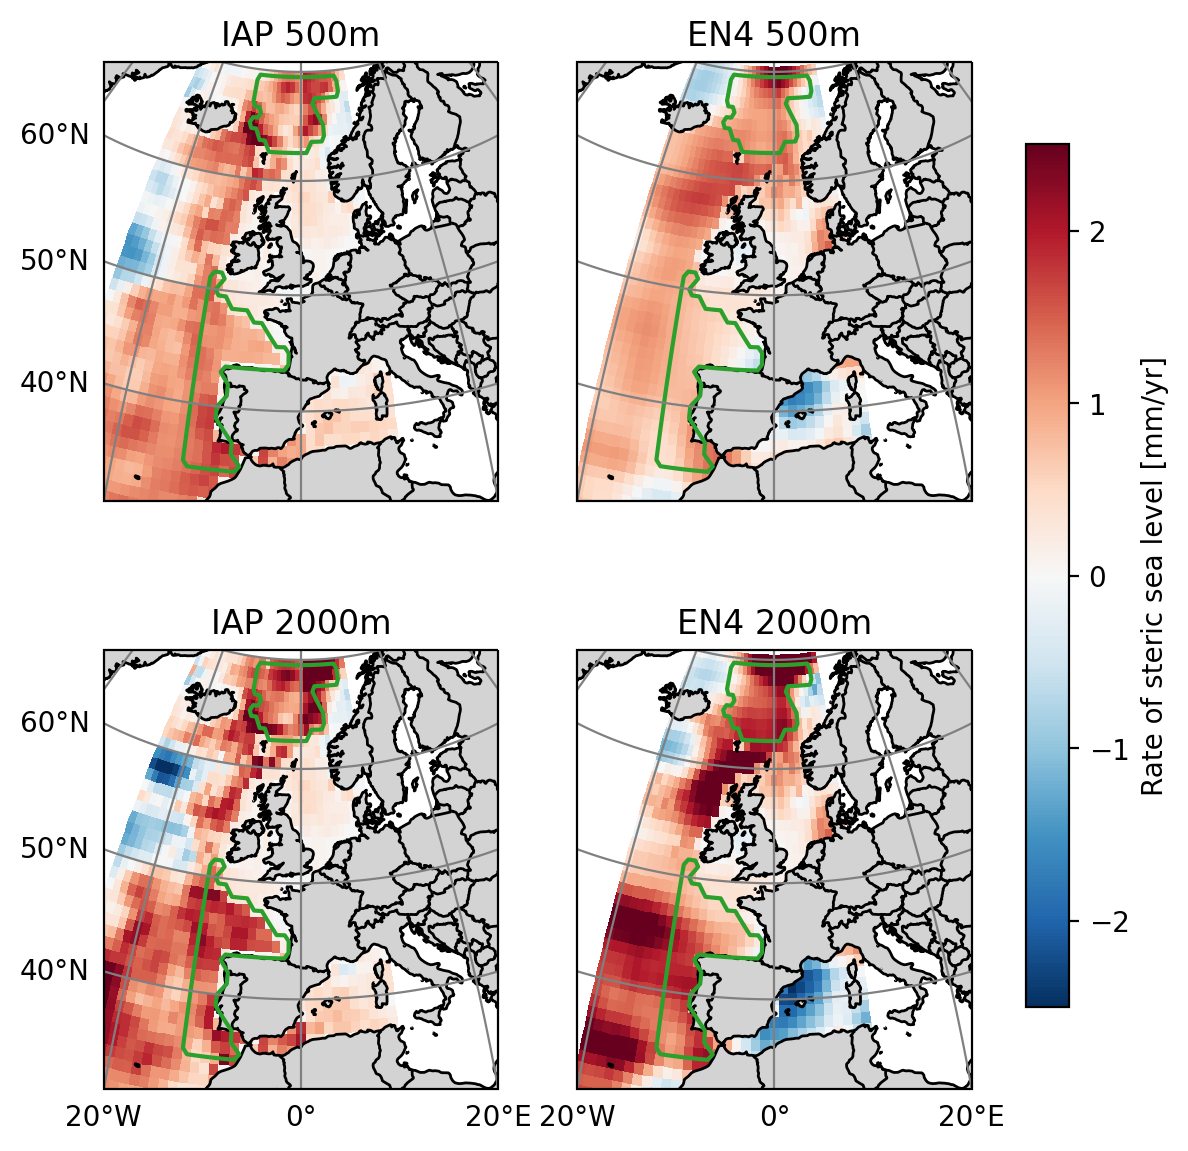

In [54]:
vm = 2.5
lon_min, lon_max, lat_min, lat_max = -20, 20, 30, 70

fig = plt.figure(figsize=(7, 7))

for idx in range(4):
    ax = fig.add_subplot(2, 2, idx+1, projection=ccrs.Orthographic(0, 45))
    
    if idx==0:
        axes = np.array(4*[ax])

    axes[idx] = ax
    
for ax in axes:
    mask_NWS.plot.contour(
        transform=ccrs.PlateCarree(),
        levels=[0.5],
        colors="tab:green",
        ax=ax)

    mask_EBB.plot.contour(
        transform=ccrs.PlateCarree(),
        levels=[0.5],
        colors="tab:green",
        ax=ax)

titles = ["IAP 500m", "EN4 500m", "IAP 2000m", "EN4 2000m" ]

for idx, trend in enumerate([trend_IAP_500, trend_EN4_500, trend_IAP_2000, trend_EN4_2000]):
    l1 = trend.plot(
        transform=ccrs.PlateCarree(),
        vmin=-vm, 
        vmax=vm,
        cmap='RdBu_r',
        add_colorbar=False,
        ax=axes[idx])
    axes[idx].set_title(titles[idx])
    
for ax in axes:
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines()

    gl = ax.gridlines(color='grey', linestyle='-', draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    if ax in axes[0:2]:
        gl.bottom_labels = False
        
    if ax in [axes[1], axes[3]]:
        gl.left_labels = False
    
fig.colorbar(l1, ax=axes, shrink=0.8, label="Rate of steric sea level [mm/yr]")

#plt.savefig('../figures/StericTrend_1993_2021.pdf', dpi=150)